# Neuron-Like Gene Expression in Zebrafish Heart scRNA-seq

This notebook analyzes single-cell RNA sequencing data from zebrafish heart tissue (atrium and whole heart) to identify neuron-like gene expression signatures. Using scVI-based latent space representation and marker gene profiling, the analysis explores the presence of neuronal and neurotransmitter transcriptional within cardiac tissue.


In [ ]:
!pip install scanpy scvi-tools scrublet igraph louvain leidenalg


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.0 MB/s eta 0:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scanpy as sc
import scvi
import numpy as np
import scrublet as scr
import os


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
adata_atrium = sc.read_10x_mtx(
    "/content/drive/MyDrive/Cellranger/GSM8147512_atrium_mine/filtered_feature_bc_matrix",
    var_names="gene_symbols",
    make_unique=True
)

adata_heart = sc.read_10x_mtx(
    "/content/drive/MyDrive/Cellranger/GSM8147511_wholeheart_mine/filtered_feature_bc_matrix",
    var_names="gene_symbols",
    make_unique=True
)


In [ ]:
adata_atrium.obs["sample"] = "atrium"
adata_heart.obs["sample"] = "heart"


In [ ]:
common_genes = adata_atrium.var_names.intersection(adata_heart.var_names)
adata_atrium = adata_atrium[:, common_genes]
adata_heart = adata_heart[:, common_genes]


In [ ]:
adata = adata_atrium.concatenate(adata_heart, batch_key="origin", batch_categories=["atrium", "heart"])


<ipython-input-7-63f78e9e0fde>:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_atrium.concatenate(adata_heart, batch_key="origin", batch_categories=["atrium", "heart"])


In [ ]:
print(f"Number of cells after filtering for gene count and mitochondrial content: {adata.n_obs}")


Number of cells after filtering for gene count and mitochondrial content: 10076


In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

adata = adata[adata.obs.n_genes_by_counts.between(200, 5000), :]
adata = adata[adata.obs.pct_counts_mt < 5, :]


In [ ]:
print(f"Number of cells after filtering for gene count and mitochondrial content: {adata.n_obs}")


Number of cells after filtering for gene count and mitochondrial content: 6646


In [ ]:
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

adata = adata[~adata.obs['predicted_doublet'], :]


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 46.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 11.0 seconds


<ipython-input-11-308219997e2e>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = doublet_scores


In [ ]:
print(f"Number of cells after filtering for gene count and mitochondrial content: {adata.n_obs}")


Number of cells after filtering for gene count and mitochondrial content: 6596


In [ ]:
adata = adata.copy()


In [ ]:
scvi.model.SCVI.setup_anndata(adata)
model = scvi.model.SCVI(adata)
model.train()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


<ipython-input-15-7c6d4aa26fc6>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


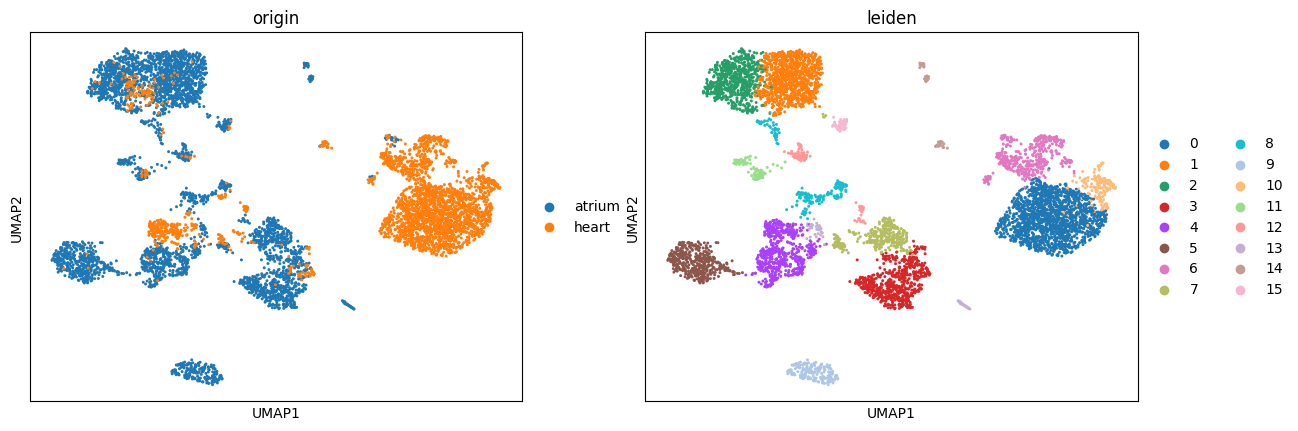

In [ ]:
adata.obsm["X_scVI"] = model.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

sc.pl.umap(adata, color=["origin", "leiden"])


In [ ]:
print(f"Number of cells after filtering for gene count and mitochondrial content: {adata.n_obs}")


Number of cells after filtering for gene count and mitochondrial content: 6596


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# gene categories
housekeeping_genes = ["actb1", "gapdh", "rpl13a", "eef1a1l1", "b2m", "hmbs", "rplp0", "rps18", "ubqln1", "hprt1",
                      "pgk1", "tbp", "rpl19", "rpl32", "rps29", "rps27a", "rpl11", "rpl7", "rpl23a", "rps9"]

heart_genes = ["myl7", "tnnt2a", "kdrl", "fli1a", "vmhc", "amhc", "nkx2.5", "gata4", "tbx5", "actc1a",
               "tnni2a", "myh6", "myh7", "notch1b", "vegfa", "cdh5", "epas1b", "tal1", "tek", "bmp4"]

neuronal_genes = ["elavl3", "elavl4", "vim", "calm1a", "gap43", "syt1a", "tac3a", "stmn2a", "tubb5", "prph",
                  "stmn4l", "hbegfa", "calm3b", "ascl1a", "vat1", "nos1", "atp6v1e1b", "anxa13l", "stmn2b",
                  "anxa5b", "dbn1", "anxa4", "stmn4", "sox11b", "calm3a", "cnp", "calb1", "stat1a", "mycbp2",
                  "dpysl3", "cdh2", "dll4", "sv2a", "calb2a", "ddc", "sncb", "fhl1b", "rtn4b", "chata", "chrna5",
                  "sox2", "slc29a4", "slc18a3a", "galnt1", "dab2ipa", "insm1a", "ncaldb", "bmpr2a", "apc",
                  "ing2", "plxna4", "pcna", "tbh1a", "adra2a", "nell2b", "cald1b", "slc44a2", "slc5a7a", "nrgna", "plp1b"]

neurotransmitter_genes = ["chrna5", "htr1fa", "ptk2bb", "grid2", "grm1a", "gria2a", "glrbb", "chrna3", "chrnb4",
                          "chrm2a", "gria3b", "grid1b", "gabrg2", "glra1", "chrm4a", "gabra6b", "gabbr1a", "chrna1",
                          "gria4b", "glra4a", "grik4", "gabrg3", "adrb1", "chrm1b", "chrnb1", "chrne", "chrng",
                          "drd1a", "drd5a", "gabra6a", "gabrr2a", "gabrr3a", "glra2", "glra3", "gpr158a", "gpr158b",
                          "gria1a", "grik1a", "grik5", "grin1a", "grin1b", "grin2bb", "grin2da", "grin3a", "grin3bb",
                          "hrh3", "htr1ab", "htr1b", "htr2aa", "htr2b", "htr2cl1", "htr3a", "htr4", "htr6", "htr7c",
                          "ptk2ba"]


In [ ]:
def get_valid_genes(adata, gene_list):
    return [gene for gene in gene_list if gene in adata.var_names]

valid_neuronal = get_valid_genes(adata, neuronal_genes)
valid_neurotransmitter = get_valid_genes(adata, neurotransmitter_genes)
valid_heart = get_valid_genes(adata, heart_genes)
valid_housekeeping = get_valid_genes(adata, housekeeping_genes)


In [ ]:
# Compute total expression for each category
def compute_expression(adata, gene_list):
    if len(gene_list) > 0:
        return adata[:, gene_list].X.sum()
    return 0

total_housekeeping = compute_expression(adata, valid_housekeeping)
total_heart = compute_expression(adata, valid_heart)
total_neuronal = compute_expression(adata, valid_neuronal)
total_neurotransmitter = compute_expression(adata, valid_neurotransmitter)


In [ ]:
# expression values for a list of genes
def print_gene_expression(ad, gene_list, category_name):
    print(f"\n--- {category_name} Genes ---")
    for gene in gene_list:
        if gene in ad.var_names:
            expression = ad[:, gene].X.sum()
            print(f"{gene}: {expression:.2f}")
        else:
            print(f"{gene}: not found in dataset")

print_gene_expression(adata, valid_neuronal, " 🧠 Neuronal")
print_gene_expression(adata, valid_neurotransmitter, " ⚡ Neurotransmitter")
print_gene_expression(adata, valid_heart, " 🫀 Heart")
print_gene_expression(adata, valid_housekeeping, " ⚙️ Housekeeping")



---  🧠 Neuronal Genes ---
elavl3: 286.00
elavl4: 312.00
vim: 23557.00
calm1a: 15932.00
gap43: 244.00
syt1a: 550.00
tac3a: 99.00
stmn2a: 188.00
tubb5: 291.00
prph: 149.00
stmn4l: 797.00
hbegfa: 16745.00
calm3b: 4845.00
ascl1a: 75.00
vat1: 5178.00
nos1: 1260.00
atp6v1e1b: 8931.00
anxa13l: 161.00
stmn2b: 74.00
anxa5b: 4002.00
dbn1: 1610.00
anxa4: 12150.00
stmn4: 111.00
sox11b: 564.00
calm3a: 10958.00
cnp: 3056.00
calb1: 66.00
stat1a: 7085.00
mycbp2: 2975.00
dpysl3: 748.00
cdh2: 7012.00
dll4: 1774.00
sv2a: 94.00
calb2a: 53.00
ddc: 301.00
sncb: 72.00
fhl1b: 1481.00
rtn4b: 522.00
chata: 37.00
chrna5: 62.00
sox2: 37.00
slc29a4: 103.00
slc18a3a: 28.00
galnt1: 3152.00
dab2ipa: 578.00
insm1a: 12.00
ncaldb: 511.00
bmpr2a: 982.00
apc: 616.00
ing2: 263.00
plxna4: 116.00
pcna: 1901.00
adra2a: 25.00
nell2b: 42.00
cald1b: 687.00
slc44a2: 2882.00
slc5a7a: 19.00
nrgna: 131.00
plp1b: 334.00

---  ⚡ Neurotransmitter Genes ---
chrna5: 62.00
htr1fa: 28.00
ptk2bb: 34.00
grid2: 440.00
grm1a: 35.00
gria2a: 12

###Note: Percentages represent the proportion of total expression from the selected gene categories (housekeeping, heart-specific, neuronal, and neurotransmitter-related genes), not from the full transcriptome.


In [ ]:

total_expression = total_housekeeping + total_heart + total_neuronal + total_neurotransmitter


housekeeping_ratio = (total_housekeeping / total_expression) * 100
heart_ratio = (total_heart / total_expression) * 100
neuronal_ratio = (total_neuronal / total_expression) * 100
neurotransmitter_ratio = (total_neurotransmitter / total_expression) * 100


print(f"Housekeeping genes: {len(valid_housekeeping)}/{len(housekeeping_genes)} present, {housekeeping_ratio:.2f}% of total expression")
print(f"Heart-specific genes: {len(valid_heart)}/{len(heart_genes)} present, {heart_ratio:.2f}% of total expression")
print(f"Neuronal genes: {len(valid_neuronal)}/{len(neuronal_genes)} present, {neuronal_ratio:.2f}% of total expression")
print(f"Neurotransmitter receptor genes: {len(valid_neurotransmitter)}/{len(neurotransmitter_genes)} present, {neurotransmitter_ratio:.2f}% of total expression")


Housekeeping genes: 18/20 present, 71.73% of total expression
Heart-specific genes: 15/20 present, 24.73% of total expression
Neuronal genes: 59/60 present, 3.39% of total expression
Neurotransmitter receptor genes: 53/56 present, 0.16% of total expression


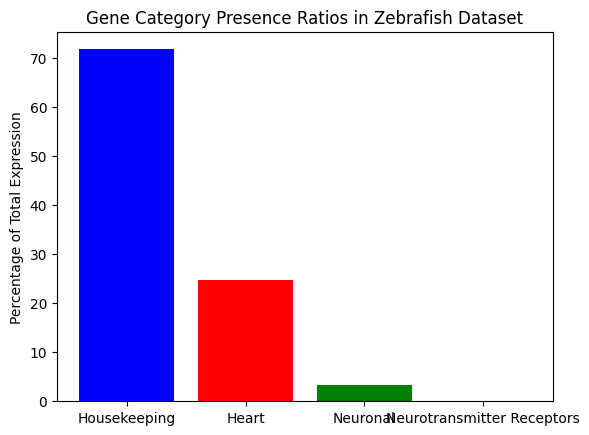

In [ ]:

categories = ["Housekeeping", "Heart", "Neuronal", "Neurotransmitter Receptors"]
ratios = [housekeeping_ratio, heart_ratio, neuronal_ratio, neurotransmitter_ratio]

plt.bar(categories, ratios, color=["blue", "red", "green", "purple"])
plt.title("Gene Category Presence Ratios in Zebrafish Dataset")
plt.ylabel("Percentage of Total Expression")
plt.show()


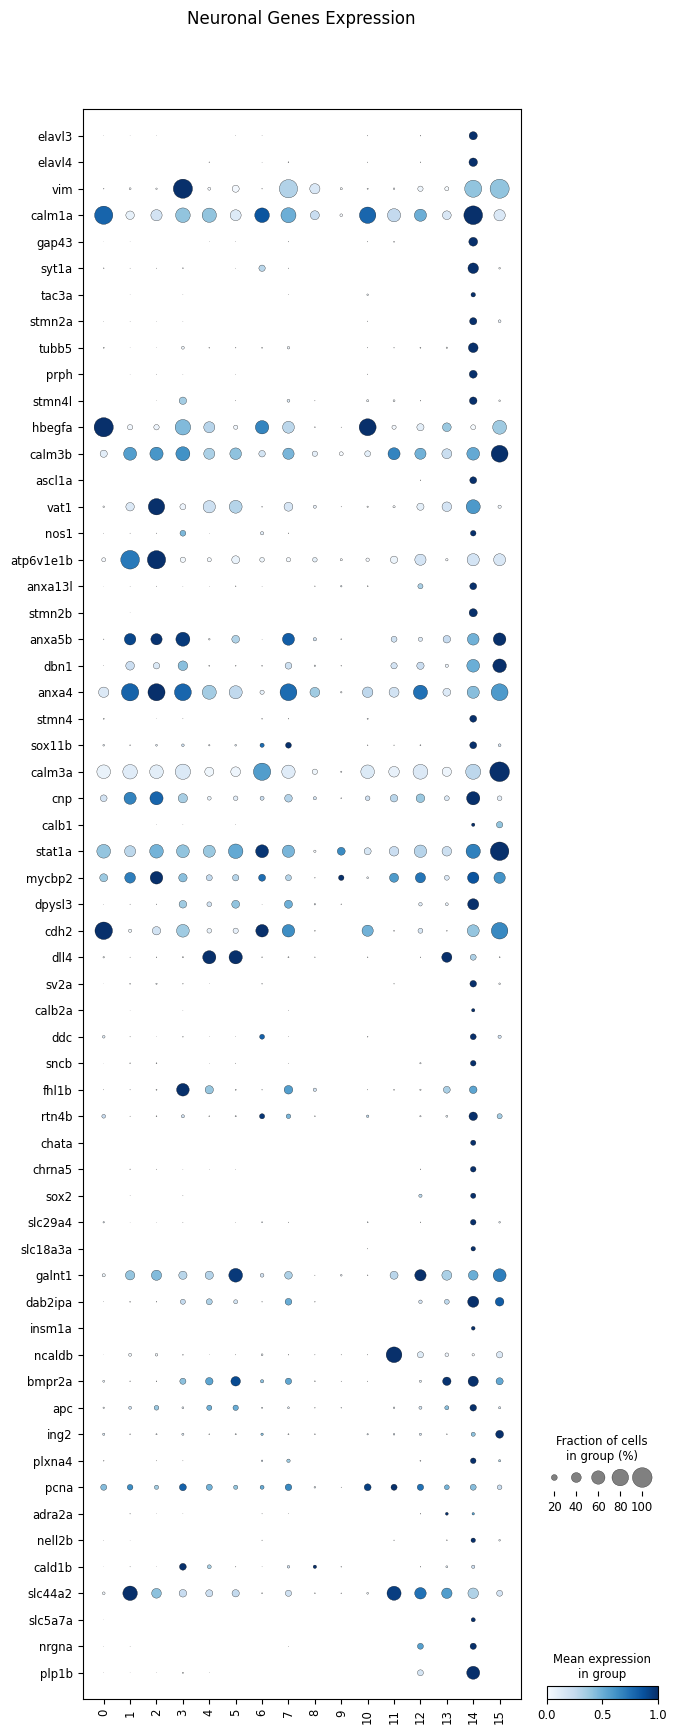

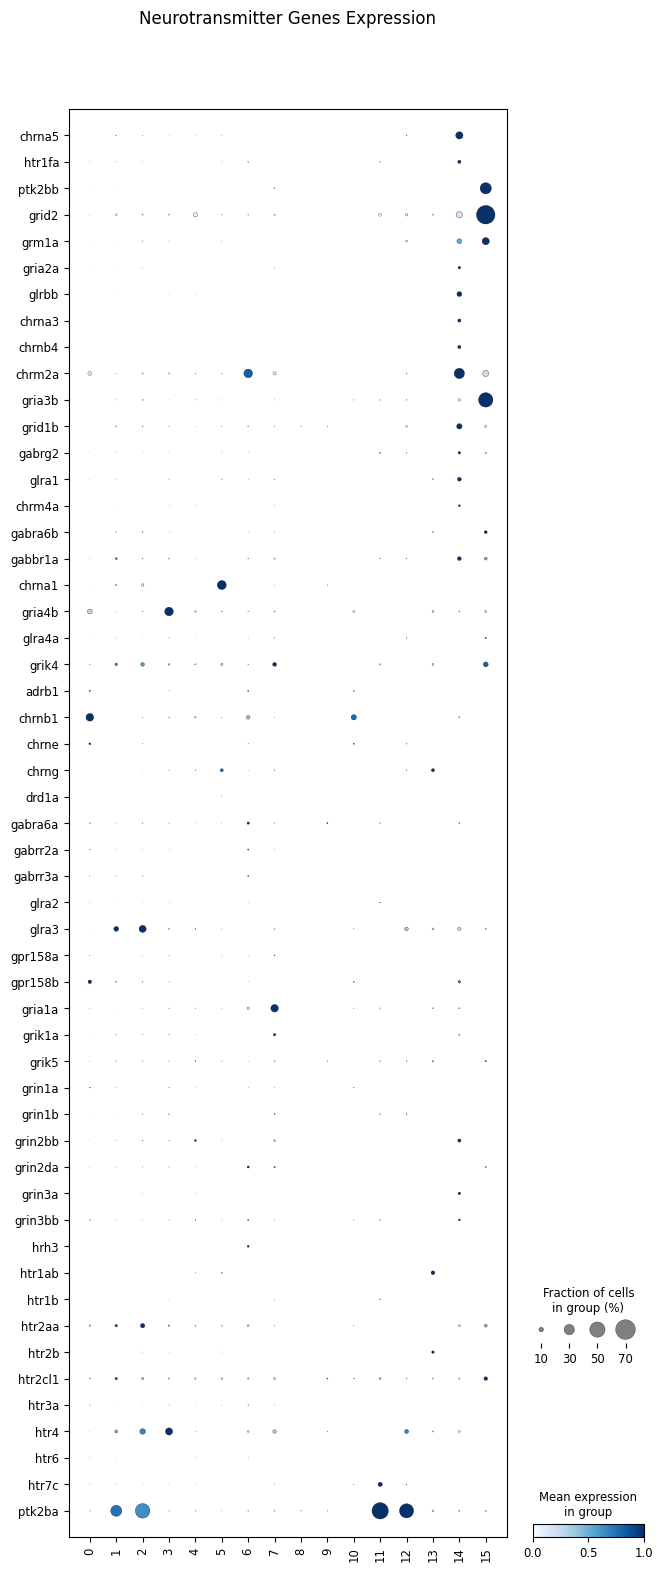

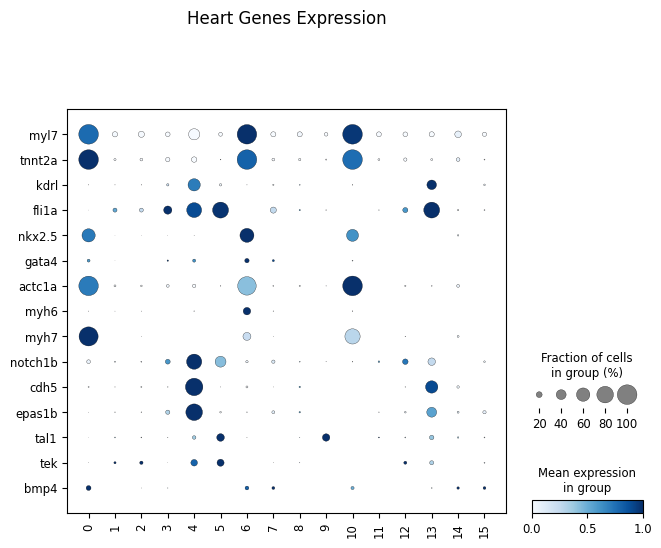

In [ ]:
sc.pl.dotplot(adata, var_names=valid_neuronal, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Neuronal Genes Expression")
sc.pl.dotplot(adata, var_names=valid_neurotransmitter, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Neurotransmitter Genes Expression")
sc.pl.dotplot(adata, var_names=valid_heart, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Heart Genes Expression")


<ipython-input-27-606802495c5d>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(adata.obs["leiden"]).mean()


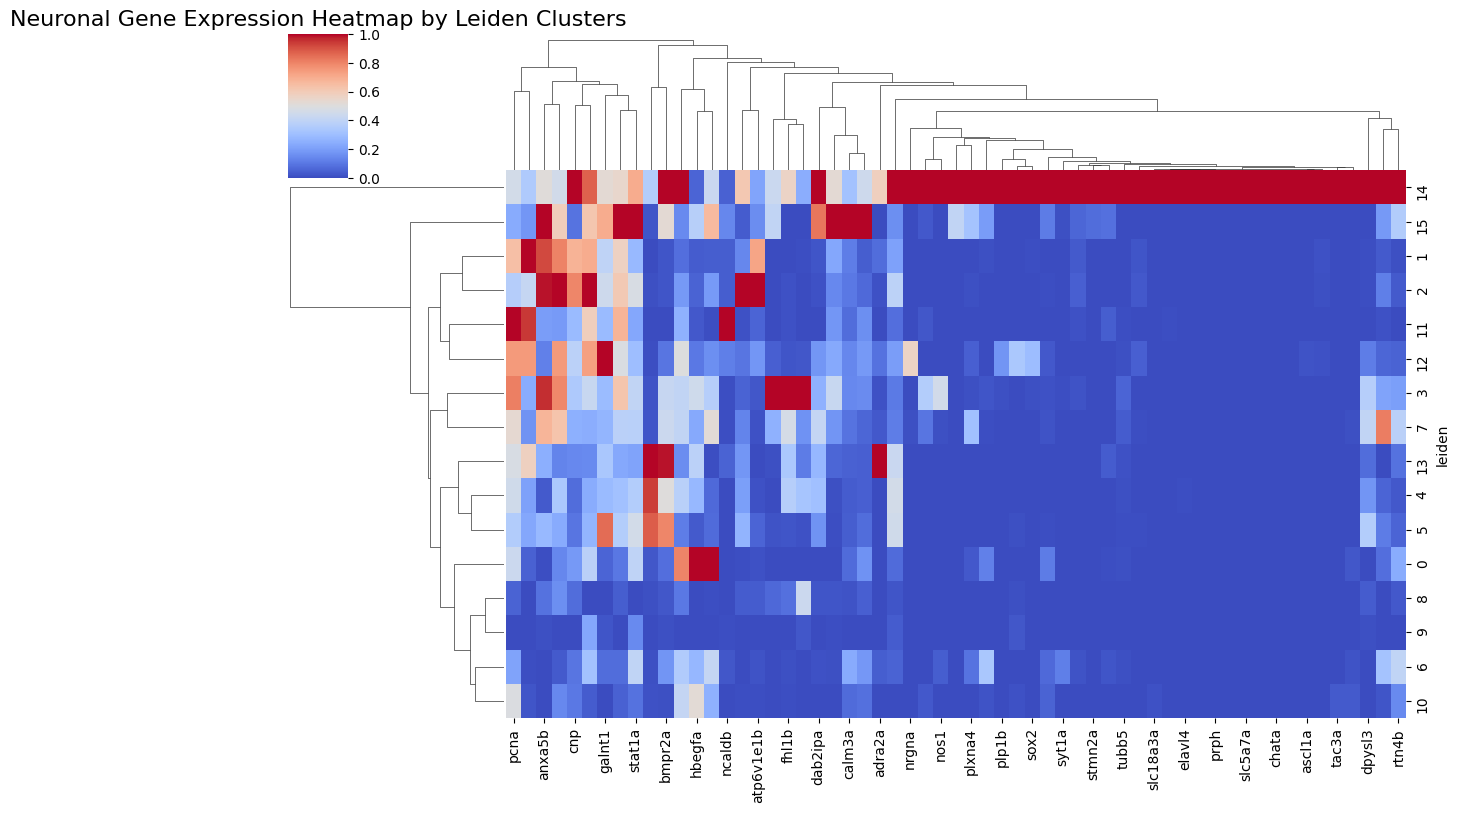

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(
    adata[:, valid_neuronal].X.toarray(),
    index=adata.obs.index,
    columns=valid_neuronal
)

df_grouped = df.groupby(adata.obs["leiden"]).mean()

sns.clustermap(
    df_grouped,
    cmap="coolwarm",
    method="average",
    metric="euclidean",
    standard_scale=1,
    figsize=(12, 8)
)
plt.title("Neuronal Gene Expression Heatmap by Leiden Clusters", fontsize=16)
plt.show()
